# Passive Learning (Manual)

## 1. Data Preprocessing

In [1]:
# Birth-Death Record Linkage Analysis
# A comprehensive record linkage system for linking birth and death records

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from datasketch import MinHash, MinHashLSH
# from jellyfish import jaro_winkler, damerau_levenshtein_distance
from jellyfish import jaro_similarity, jaro_winkler_similarity, levenshtein_distance, damerau_levenshtein_distance
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Birth-Death Record Linkage System")
print("=" * 50)

# %% [markdown]
# ## Step 1: Data Preprocessing


# %%
# Load the datasets
print("Loading datasets...")

# corrupted data (500k)
birth_df = pd.read_csv('../../linkage data/data_500k/corrupted/birth_records.csv')
death_df = pd.read_csv('../../linkage data/data_500k/corrupted/death_records.csv')

print(f"Birth records: {birth_df.shape[0]} rows, {birth_df.shape[1]} columns")
print(f"Death records: {death_df.shape[0]} rows, {death_df.shape[1]} columns")

# %%
# Examine the structure of both datasets
print("\nBirth Records Columns:")
print(birth_df.columns.tolist())
print(f"\nDeath Records Columns:")
print(death_df.columns.tolist())

# %%
# Check for missing values
print("\nMissing values in Birth Records:")
print(birth_df.isnull().sum().head(10))
print(f"\nMissing values in Death Records:")
print(death_df.isnull().sum().head(10))

# %%
# Data preprocessing - select relevant columns for linkage
birth_columns = [
    'ID', 'child\'s forname(s)', 'child\'s surname', 'sex', 
    'father\'s forename', 'father\'s surname', 'father\'s occupation',
    'mother\'s forename', 'mother\'s maiden surname', 'mother\'s occupation',
    'birth year', 'address', 'Death'
]

death_columns = [
    'ID', 'forename(s) of deceased', 'surname of deceased', 'sex',
    'father\'s forename', 'father\'s surname', 'father\'s occupation',
    'mother\'s forename', 'mother\'s maiden surname', 'mother\'s occupation',
    'year', 'address', 'age at death'
]

# Create clean datasets
birth_clean = birth_df[birth_columns].copy()
death_clean = death_df[death_columns].copy()

# Rename columns for consistency
birth_clean.columns = ['birth_id', 'forename', 'surname', 'sex', 
                       'father_forename', 'father_surname', 'father_occupation',
                       'mother_forename', 'mother_surname', 'mother_occupation',
                       'birth_year', 'address', 'death_link']

death_clean.columns = ['death_id', 'forename', 'surname', 'sex',
                       'father_forename', 'father_surname', 'father_occupation', 
                       'mother_forename', 'mother_surname', 'mother_occupation',
                       'death_year', 'address', 'age_at_death']

# Fill missing values with empty strings for string columns
string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
               'father_occupation', 'mother_forename', 'mother_surname', 
               'mother_occupation', 'address']

for col in string_cols:
    birth_clean[col] = birth_clean[col].fillna('').astype(str)
    death_clean[col] = death_clean[col].fillna('').astype(str)

print(f"\nCleaned Birth Records: {birth_clean.shape}")
print(f"Cleaned Death Records: {death_clean.shape}")


Birth-Death Record Linkage System
Loading datasets...
Birth records: 1297360 rows, 39 columns
Death records: 1297360 rows, 38 columns

Birth Records Columns:
['ID', 'family', 'marriage', "child's forname(s)", "child's surname", 'birth day', 'birth month', 'birth year', 'address', 'sex', "father's forename", "father's surname", "father's occupation", "mother's forename", "mother's maiden surname", "mother's occupation", "day of parents' marriage", "month of parents' marriage", "year of parents' marriage", "place of parent's marriage", 'illegit', 'notes', 'Death', 'CHILD_IDENTITY', 'MOTHER_IDENTITY', 'FATHER_IDENTITY', 'DEATH_RECORD_IDENTITY', 'PARENT_MARRIAGE_RECORD_IDENTITY', 'FATHER_BIRTH_RECORD_IDENTITY', 'MOTHER_BIRTH_RECORD_IDENTITY', 'MARRIAGE_RECORD_IDENTITY1', 'MARRIAGE_RECORD_IDENTITY2', 'MARRIAGE_RECORD_IDENTITY3', 'MARRIAGE_RECORD_IDENTITY4', 'MARRIAGE_RECORD_IDENTITY5', 'MARRIAGE_RECORD_IDENTITY6', 'MARRIAGE_RECORD_IDENTITY7', 'MARRIAGE_RECORD_IDENTITY8', 'IMMIGRANT_GENERATI

### Ground-truth function
- can adjust the `data_size`

In [2]:

# Sample both datasets to XX rows
data_size = 1500000 # go with the max size = 1.3 M rows
# data_size = 300000
print(f"Sampling datasets to {data_size} rows each...")
print("=" * 40)

# Original sizes
print(f"Original birth records: {len(birth_clean):,}")
print(f"Original death records: {len(death_clean):,}")

# Sample birth records to XX rows
birth_sample_size = min(data_size, len(birth_clean))
birth_sampled = birth_clean.sample(n=birth_sample_size, random_state=42).reset_index(drop=True)

# Sample death records to XX rows  
death_sample_size = min(data_size, len(death_clean))
death_sampled = death_clean.sample(n=death_sample_size, random_state=42).reset_index(drop=True)

print(f"Sampled birth records: {len(birth_sampled):,}")
print(f"Sampled death records: {len(death_sampled):,}")
print(f"Total pairs to create: {len(birth_sampled) * len(death_sampled):,}")

# Use sampled data for ground truth
birth_clean = birth_sampled
death_clean = death_sampled

print("Sampling completed!")
print()

def create_efficient_ground_truth(birth_df, death_df):
    """
    Most efficient approach: directly create ground truth from death_link column
    Only creates records for actual linked pairs, O(n) complexity
    """
    ground_truth = []
    
    # Create death_id lookup for validation
    valid_death_ids = set(death_df['death_id'].values)
    
    for _, birth_row in birth_df.iterrows():
        birth_id = birth_row['birth_id']
        death_link = birth_row['death_link']
        
        # Only process records with valid death links
        if pd.notna(death_link):
            # Verify the death_id exists in death records
            if death_link in valid_death_ids:
                ground_truth.append({
                    'birth_id': birth_id,
                    'death_id': death_link,
                    'label': 1  # This is a confirmed match
                })
    
    return pd.DataFrame(ground_truth)


ground_truth_df = create_efficient_ground_truth(birth_clean, death_clean)

print(f"\nGround truth created: {len(ground_truth_df)} record pairs")
print(f"Positive matches: {ground_truth_df['label'].sum()}")
print(f"Negative matches: {len(ground_truth_df) - ground_truth_df['label'].sum()}")


Sampling datasets to 1500000 rows each...
Original birth records: 1,297,360
Original death records: 1,297,360
Sampled birth records: 1,297,360
Sampled death records: 1,297,360
Total pairs to create: 1,683,142,969,600
Sampling completed!


Ground truth created: 1297360 record pairs
Positive matches: 1297360
Negative matches: 0


In [3]:
# ground_truth_df.loc[ground_truth_df['label'] == 1]
print(ground_truth_df)
print(ground_truth_df.loc[ground_truth_df['label'] == 1])

         birth_id  death_id  label
0         1474005   1474005      1
1         1832197   1832197      1
2         1874508   1874508      1
3         1588408   1588408      1
4         2243616   2243616      1
...           ...       ...    ...
1297355   1897259   1897259      1
1297356   2444811   2444811      1
1297357   1939747   1939747      1
1297358   1813214   1813214      1
1297359   1918301   1918301      1

[1297360 rows x 3 columns]
         birth_id  death_id  label
0         1474005   1474005      1
1         1832197   1832197      1
2         1874508   1874508      1
3         1588408   1588408      1
4         2243616   2243616      1
...           ...       ...    ...
1297355   1897259   1897259      1
1297356   2444811   2444811      1
1297357   1939747   1939747      1
1297358   1813214   1813214      1
1297359   1918301   1918301      1

[1297360 rows x 3 columns]


## 2. Indexing (Blocking)

In [4]:
def create_minhash_signature(record, columns):
    """Create MinHash signature for a record"""
    minhash = MinHash()
    for col in columns:
        data = str(record[col]).lower()
        for token in data.split():
            minhash.update(token.encode('utf8'))
    return minhash

def blocking_with_minhash(birth_df, death_df, threshold):
    """Create blocks using MinHash LSH"""
    print(f"Creating blocks with threshold: {threshold}")
    
    # Columns to use for blocking
    blocking_cols = ['forename', 'surname', 'father_surname', 'mother_surname']
    
    # Create MinHash signatures for all records
    birth_signatures = {}
    death_signatures = {}
    
    print("Creating MinHash signatures for birth records...")
    for idx, row in birth_df.iterrows():
        birth_signatures[f"birth_{row['birth_id']}"] = create_minhash_signature(row, blocking_cols)
    
    print("Creating MinHash signatures for death records...")
    for idx, row in death_df.iterrows():
        death_signatures[f"death_{row['death_id']}"] = create_minhash_signature(row, blocking_cols)
    
    # Create LSH index
    lsh = MinHashLSH(threshold=threshold)
    
    # Insert all signatures
    print("Inserting signatures into LSH index...")
    for key, sig in birth_signatures.items():
        lsh.insert(key, sig)
    for key, sig in death_signatures.items():
        lsh.insert(key, sig)
    
    # Generate candidate pairs and detailed blocking information
    candidate_pairs = []
    birth_blocks = {}  # Dictionary to store blocks for each birth record
    
    print("Generating candidate pairs...")
    for birth_key, birth_sig in birth_signatures.items():
        similar_records = lsh.query(birth_sig)
        birth_id = int(birth_key.split('_')[1])
        
        # Find death records in the same block
        death_records_in_block = []
        for similar_key in similar_records:
            if similar_key.startswith('death_'):
                death_id = int(similar_key.split('_')[1])
                candidate_pairs.append((birth_id, death_id))
                death_records_in_block.append(death_id)
        
        # Store block information (just for statistical purposes)
        birth_blocks[birth_id] = {
            'birth_id': birth_id,
            'death_records': death_records_in_block,
            'total_similar_records': len(similar_records),
            'death_count': len(death_records_in_block)
        }
    
    # Remove duplicates from candidate pairs
    candidate_pairs = list(set(candidate_pairs))
    
    print(f"Generated {len(candidate_pairs)} candidate pairs") # for computation
    print(f"Generated {len(birth_blocks)} birth blocks") # for illustration, exploration
    
    return candidate_pairs, birth_blocks

# Generate candidate pairs through blocking
candidate_pairs, birth_blocks = blocking_with_minhash(birth_clean, death_clean, threshold=0.9)


Creating blocks with threshold: 0.9
Creating MinHash signatures for birth records...
Creating MinHash signatures for death records...
Inserting signatures into LSH index...
Generating candidate pairs...
Generated 649513 candidate pairs
Generated 1297360 birth blocks


- checking the candidate pair that is same with the birth_blocks variable
- the diff is only the data types
- And, birth_blocks count the one that dont have the death (candidate)

In [5]:
def checking_candidate_pairs_by_ID(checking_id):
    r = []
    for i in range(len(candidate_pairs)):
        if candidate_pairs[i][0] == checking_id:
            r.append(candidate_pairs[i])
    print(f"\nCandidate pairs for birth ID {checking_id}: {r}")
    print(f"Total candidate pairs for birth ID {checking_id}: {len(r)}")

checking_candidate_pairs_by_ID(checking_id=1383518)
checking_candidate_pairs_by_ID(checking_id=2532606)
checking_candidate_pairs_by_ID(checking_id=1276997)




Candidate pairs for birth ID 1383518: [(1383518, 1383518), (1383518, 1644270)]
Total candidate pairs for birth ID 1383518: 2

Candidate pairs for birth ID 2532606: []
Total candidate pairs for birth ID 2532606: 0

Candidate pairs for birth ID 1276997: [(1276997, 1276997)]
Total candidate pairs for birth ID 1276997: 1


In [6]:
candidate_pairs

[(768331, 768331),
 (1943094, 1943094),
 (2941038, 2941038),
 (1438740, 1438740),
 (1932330, 1932330),
 (923622, 923622),
 (2104255, 2104255),
 (1599901, 1599901),
 (1849143, 1849143),
 (1095547, 1095547),
 (1516714, 1516714),
 (1448513, 1448513),
 (1697755, 1697755),
 (1431879, 1431879),
 (678283, 678283),
 (1858916, 1858916),
 (1354562, 1354562),
 (1603804, 1603804),
 (2280083, 2280083),
 (1775729, 1775729),
 (1203174, 1203174),
 (698820, 698820),
 (1613577, 1613577),
 (854111, 854111),
 (2034744, 2034744),
 (1530390, 1530390),
 (2709375, 2709375),
 (1015272, 1015272),
 (863673, 2980703),
 (1196313, 1196313),
 (1197961, 1197961),
 (1368238, 1368238),
 (863884, 863884),
 (2293759, 2293759),
 (1787757, 1787757),
 (1789405, 1789405),
 (1035809, 1035809),
 (2532237, 2532237),
 (2277125, 2277125),
 (1274287, 1274287),
 (1455328, 1455328),
 (952622, 952622),
 (2131607, 2131607),
 (2125737, 2125737),
 (1876495, 1876495),
 (1971717, 1986861),
 (1372141, 1372141),
 (2046772, 2046772),
 (22976

### Blocking Statistics


Detailed Blocking Analysis:
Sample Blocks (First 15 Birth Records):
----------------------------------------
Block 1:
  Birth ID: 1474005
  Associated Death Records: []
  Number of Death Records: 0
  Birth Record: Cohneor Sauners
  No death records in this block
---
Block 2:
  Birth ID: 1832197
  Associated Death Records: []
  Number of Death Records: 0
  Birth Record: Andrew Jackson
  No death records in this block
---
Block 3:
  Birth ID: 1874508
  Associated Death Records: []
  Number of Death Records: 0
  Birth Record: K?ira Sim
  No death records in this block
---
Block 4:
  Birth ID: 1588408
  Associated Death Records: [1588408]
  Number of Death Records: 1
  Birth Record: Hebe Thomson
  Death Record(s):
    ID 1588408: Hebe Thomson
---
Block 5:
  Birth ID: 2243616
  Associated Death Records: []
  Number of Death Records: 0
  Birth Record: Whiteltw Holly
  No death records in this block
---
Block 6:
  Birth ID: 1381219
  Associated Death Records: [1381219]
  Number of Death Reco

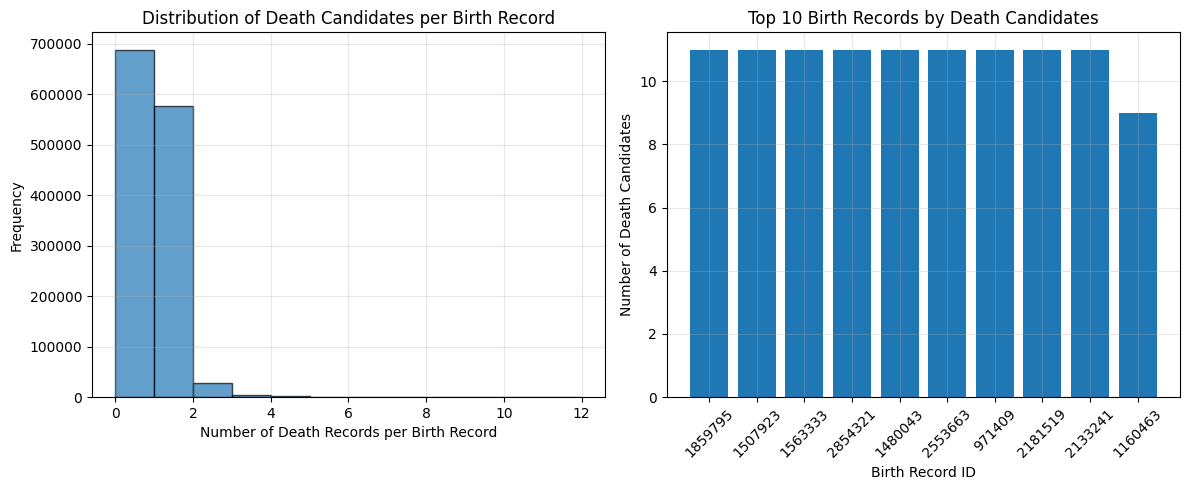


Birth Records with Multiple Death Candidates:
--------------------------------------------------
Found 32526 birth records with multiple death candidates:

Birth ID 1859795: Macdonald Daniel
  Death candidates (11):
    ID 2133241: Daniel Macdonald (Age: 67)
    ID 1480043: Daniel Smith (Age: 51)
    ID 2181519: Daniel Macdonald (Age: 63)
    ID 737691: Daniel Smith (Age: 63)
    ID 971409: Daniel Macdonald (Age: 50)
    ID 1859795: Daniel Macdonald (Age: 73)
    ID 2553663: Daniel Macdonald (Age: 25)
    ID 1507923: Daniel Macdonald (Age: 26)
    ID 1563333: Daniel Macdonald (Age: 44)
    ID 2854321: Daniel Smith (Age: 11)
    ID 1914141: Daniel Macdonald (Age: 50)

Birth ID 1507923: Daniel Macdonald
  Death candidates (11):
    ID 2133241: Daniel Macdonald (Age: 67)
    ID 1480043: Daniel Smith (Age: 51)
    ID 2181519: Daniel Macdonald (Age: 63)
    ID 737691: Daniel Smith (Age: 63)
    ID 971409: Daniel Macdonald (Age: 50)
    ID 1859795: Daniel Macdonald (Age: 73)
    ID 2553663:

In [7]:
# Show detailed blocking results
print("\nDetailed Blocking Analysis:")
print("=" * 50)

# Show first 15 birth records and their associated death records
print("Sample Blocks (First 15 Birth Records):")
print("-" * 40)

birth_ids_sample = list(birth_blocks.keys())[:15]
for i, birth_id in enumerate(birth_ids_sample):
    block_info = birth_blocks[birth_id]
    print(f"Block {i+1}:")
    print(f"  Birth ID: {birth_id}")
    print(f"  Associated Death Records: {block_info['death_records']}")
    print(f"  Number of Death Records: {block_info['death_count']}")
    # print(f"  Total Similar Records: {block_info['total_similar_records']}")
    
    # Show names for context
    birth_record = birth_clean[birth_clean['birth_id'] == birth_id].iloc[0]
    print(f"  Birth Record: {birth_record['forename']} {birth_record['surname']}")
    
    if block_info['death_records']:
        print(f"  Death Record(s):")
        for death_id in block_info['death_records']:
            death_record = death_clean[death_clean['death_id'] == death_id]
            if not death_record.empty:
                death_record = death_record.iloc[0]
                print(f"    ID {death_id}: {death_record['forename']} {death_record['surname']}")
    else:
        print(f"  No death records in this block")
    print("---")

# %%
# Statistical analysis of blocking results
print(f"\nBlocking Statistics:")
print("=" * 30)

death_counts = [block_info['death_count'] for block_info in birth_blocks.values()]
birth_records_with_deaths = sum(1 for count in death_counts if count > 0)
birth_records_without_deaths = sum(1 for count in death_counts if count == 0)

print(f"Total birth records: {len(birth_blocks)}")
print(f"Birth records with death candidates: {birth_records_with_deaths}")
print(f"Birth records without death candidates: {birth_records_without_deaths}")
print(f"Average death candidates per birth record: {np.mean(death_counts):.2f}")
print(f"Max death candidates for a single birth record: {max(death_counts)}")

# %%
# Distribution of death record counts per birth record
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(death_counts, bins=range(max(death_counts)+2), alpha=0.7, edgecolor='black')
plt.xlabel('Number of Death Records per Birth Record')
plt.ylabel('Frequency')
plt.title('Distribution of Death Candidates per Birth Record')
plt.grid(True, alpha=0.3)

# Show birth records with most death candidates
plt.subplot(1, 2, 2)
top_candidates = sorted(birth_blocks.items(), key=lambda x: x[1]['death_count'], reverse=True)[:10]
birth_ids = [str(item[0]) for item in top_candidates]
death_counts_top = [item[1]['death_count'] for item in top_candidates]

plt.bar(birth_ids, death_counts_top)
plt.xlabel('Birth Record ID')
plt.ylabel('Number of Death Candidates')
plt.title('Top 10 Birth Records by Death Candidates')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Show birth records with multiple death candidates
print(f"\nBirth Records with Multiple Death Candidates:")
print("-" * 50)

multiple_candidates = {birth_id: info for birth_id, info in birth_blocks.items() 
                      if info['death_count'] > 1}

if multiple_candidates:
    print(f"Found {len(multiple_candidates)} birth records with multiple death candidates:")
    
    for birth_id, block_info in sorted(multiple_candidates.items(), 
                                      key=lambda x: x[1]['death_count'], reverse=True)[:10]:
        birth_record = birth_clean[birth_clean['birth_id'] == birth_id].iloc[0]
        print(f"\nBirth ID {birth_id}: {birth_record['forename']} {birth_record['surname']}")
        print(f"  Death candidates ({block_info['death_count']}):")
        
        for death_id in block_info['death_records']:
            death_record = death_clean[death_clean['death_id'] == death_id]
            if not death_record.empty:
                death_record = death_record.iloc[0]
                print(f"    ID {death_id}: {death_record['forename']} {death_record['surname']} "
                      f"(Age: {death_record['age_at_death']})")
else:
    print("No birth records have multiple death candidates with this threshold.")

# %%
# Summary table
print(f"\nBlocking Summary Table:")
print("=" * 25)

summary_data = []
for count in range(max(death_counts) + 1):
    freq = death_counts.count(count)
    percentage = (freq / len(death_counts)) * 100
    summary_data.append({
        'Death_Candidates': count,
        'Birth_Records': freq,
        'Percentage': f"{percentage:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


## 3. Comparing
### Feature
- from append()
- these are the features in each columns
1. jaro winkler
2. damerau levenshtein
3. jaccard similarity
4. age consistency 

In [8]:

# %% [markdown]
# ## Step 3: Comparing (Feature Engineering)

# %%
def jaccard_similarity(str1, str2):
    """Calculate Jaccard similarity between two strings"""
    set1 = set(str1.lower().split())
    set2 = set(str2.lower().split())
    if len(set1.union(set2)) == 0:
        return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

def calculate_features(birth_record, death_record):
    """Calculate similarity features between two records"""
    features = []
    
    # String comparison columns
    string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
                   'mother_forename', 'mother_surname', 'address']
    
    for col in string_cols:
        birth_val = str(birth_record[col]).lower()
        death_val = str(death_record[col]).lower()
        
        # Jaro-Winkler similarity
        jw_sim = jaro_winkler_similarity(birth_val, death_val)
        features.append(jw_sim)
        # features.append({'col': col, 'jw_sim': jw_sim})
        
        # Damerau-Levenshtein distance (normalized)
        dl_dist = damerau_levenshtein_distance(birth_val, death_val)
        max_len = max(len(birth_val), len(death_val))
        dl_sim = 1 - (dl_dist / max_len) if max_len > 0 else 1
        features.append(dl_sim)
        # features.append({'col': col, 'dl_sim': dl_sim})
        
        # Jaccard similarity
        jaccard_sim = jaccard_similarity(birth_val, death_val)
        features.append(jaccard_sim)
        # features.append({'col': col, 'jaccard_sim': jaccard_sim})

    try:
        # Convert to numeric, handling potential string inputs
        birth_year = pd.to_numeric(birth_record['birth_year'], errors='coerce')
        death_year = pd.to_numeric(death_record['death_year'], errors='coerce')  
        age_at_death = pd.to_numeric(death_record['age_at_death'], errors='coerce')
        
        if pd.notna(birth_year) and pd.notna(death_year) and pd.notna(age_at_death):
            expected_birth_year = death_year - age_at_death
            age_diff = abs(birth_year - expected_birth_year)
            age_consistency = 1 / (1 + age_diff)  # Exponential decay
            # features.append({'col': 'age_consistency', 'value': age_consistency})
            features.append(age_consistency)
        else:
            # features.append({'col': 'age_consistency', 'value': 0.5})
            features.append(0.5)
    except:
        # Fallback if conversion fails
        # features.append({'col': 'age_consistency', 'value': 0.5})
        features.append(0.5)
    
    return features

# Create feature matrix
print("Calculating features for candidate pairs...")
X = []
y = []
candidate_pairs_list = []

# Create lookup dictionaries for faster access
birth_lookup = {row['birth_id']: row for _, row in birth_clean.iterrows()} # death link
death_lookup = {row['death_id']: row for _, row in death_clean.iterrows()}
ground_truth_lookup = {(row['birth_id'], row['death_id']): row['label'] 
                      for _, row in ground_truth_df.iterrows()}

for birth_id, death_id in candidate_pairs: # use candidate pairs only
    if birth_id in birth_lookup and death_id in death_lookup:
        birth_record = birth_lookup[birth_id]
        death_record = death_lookup[death_id]
        
        features = calculate_features(birth_record, death_record)
        X.append(features)
        
        # Get ground truth label
        label = ground_truth_lookup.get((birth_id, death_id))
        label = int(label) if label is not None else 0  # Default to 0 if not found
        y.append(label)

        # Track the candidate pair for this feature row
        candidate_pairs_list.append((birth_id, death_id))

X = np.array(X)
y = np.array(y)  # Ensure labels are integers

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
# print(f"Positive class ratio: {np.sum(y)/len(y):.4f}")

print("Saving features and labels...")

# Option 1: Save as NumPy arrays (recommended for X, y)
np.save('X_features.npy', X)
np.save('y_labels.npy', y)
np.save('candidate_pairs.npy', candidate_pairs_list)

Calculating features for candidate pairs...
Feature matrix shape: (649513, 25)
Labels shape: (649513,)
Saving features and labels...


In [9]:
# y[0:20]
X[5]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.71612654, 0.3       , 0.        , 0.5       ])

In [10]:
y[:100]



array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## 4. Classification
### Cross Validation (5 folds)
- with Metrics performance; Precision, Recall, F1
- draw Plots

In [11]:

# %%
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42, stratify=y
# )

X_train, X_test, y_train, y_test, pairs_train, pairs_test = train_test_split(
    X, y, candidate_pairs_list, 
    test_size=0.3, random_state=42, stratify=y
)


## randomly select 100 candidate pairs for testing *****



print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training positive ratio: {np.sum(y_train)/len(y_train):.4f}")
print(f"Test positive ratio: {np.sum(y_test)/len(y_test):.4f}")

# %%
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# %%
# Cross-Validation Analysis (on training data only)
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer

print("\nPerforming Cross-Validation Analysis (Training Data Only)...")
print("=" * 60)

# %%
# Check if we have enough samples for cross-validation
if len(np.unique(y_train)) < 2:
    print("Warning: Only one class present in the training data. Cannot perform classification.")
    print("This might indicate:")
    print("1. Threshold too high (try lowering it)")
    print("2. Ground truth issues")
    print("3. No actual matches in the candidate pairs")
    
    # Show class distribution
    unique_classes, counts = np.unique(y_train, return_counts=True)
    for cls, count in zip(unique_classes, counts):
        print(f"Class {cls}: {count} samples")
else:
    # Define custom scorers
    scoring = {
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'f1': make_scorer(f1_score, zero_division=0)
    }

    # %%
    # Perform 5-fold stratified cross-validation on training data only
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("5-Fold Stratified Cross-Validation Results (Training Data Only):")
    print("-" * 60)

    # Initialize classifier for CV
    rf_classifier = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
    )

    # Perform cross-validation on training data only
    cv_results = cross_validate(
        rf_classifier, X_train_scaled, y_train, 
        cv=cv, scoring=scoring, 
        return_train_score=True,
        n_jobs=-1
    )

    # %%
    # Display cross-validation results
    metrics = ['precision', 'recall', 'f1']
    for metric in metrics:
        test_scores = cv_results[f'test_{metric}'] # test_precision, test_recall, test_f1
        train_scores = cv_results[f'train_{metric}'] # train_precision, train_recall, train_f1
        
        print(f"\n{metric.upper()}:")
        print(f"  Training:    {train_scores.mean():.4f} (+/- {train_scores.std() * 2:.4f})")
        print(f"  Validation:  {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")
        print(f"  CV Folds:    {test_scores}")




Training set: 454659 samples
Test set: 194854 samples
Training positive ratio: 0.9144
Test positive ratio: 0.9144

Performing Cross-Validation Analysis (Training Data Only)...
5-Fold Stratified Cross-Validation Results (Training Data Only):
------------------------------------------------------------

PRECISION:
  Training:    0.9971 (+/- 0.0001)
  Validation:  0.9970 (+/- 0.0004)
  CV Folds:    [0.99714766 0.99678756 0.9969419  0.99671402 0.99721893]

RECALL:
  Training:    0.9924 (+/- 0.0003)
  Validation:  0.9921 (+/- 0.0005)
  CV Folds:    [0.99218308 0.99259197 0.99189436 0.99220704 0.99182221]

F1:
  Training:    0.9947 (+/- 0.0001)
  Validation:  0.9945 (+/- 0.0002)
  CV Folds:    [0.99465918 0.99468534 0.99441172 0.99445543 0.99451325]


### Fit the model and do the prediction

In [12]:

# %%
# Train Random Forest classifier on training set
print(f"\n\nTraining Final Model on Training Set:")
print("-" * 40)


rf_classifier.fit(X_train_scaled, y_train)

# %%
# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1] # select all rows, 1 col

print(y_pred)
print("-"* 40)
count_of_ones = (y_pred == 1).sum()
count_of_zeros = (y_pred == 0).sum()
print("COunt of 0: ", count_of_zeros)
print("COunt of 1: ", count_of_ones)
print("-"* 40)
print(y_pred_proba)
print("Classification completed!")




Training Final Model on Training Set:
----------------------------------------
[1 0 1 ... 1 0 1]
----------------------------------------
COunt of 0:  17553
COunt of 1:  177301
----------------------------------------
[9.25577468e-01 2.35155086e-06 9.68184592e-01 ... 9.49859158e-01
 2.81477920e-06 9.68664510e-01]
Classification completed!


## 5. Evaluation
- with the test set

Classification Results:
Precision: 0.9970
Recall: 0.9920
F1-Score: 0.9945

Confusion Matrix:
[[ 16133    537]
 [  1420 176764]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     16670
           1       1.00      0.99      0.99    178184

    accuracy                           0.99    194854
   macro avg       0.96      0.98      0.97    194854
weighted avg       0.99      0.99      0.99    194854



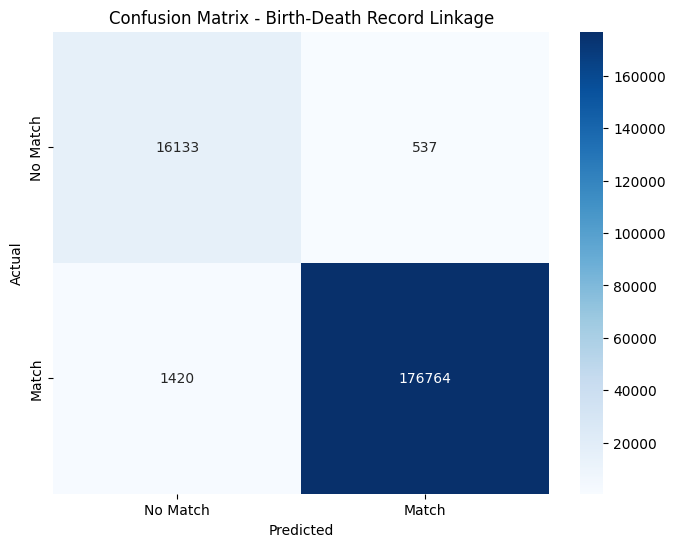


Top 10 Most Important Features:
                    feature  importance
24          age_consistency    0.401190
15       mother_forename_jw    0.144939
9        father_forename_jw    0.128032
16       mother_forename_dl    0.089318
10       father_forename_dl    0.072426
17  mother_forename_jaccard    0.057767
11  father_forename_jaccard    0.048081
18        mother_surname_jw    0.012574
19        mother_surname_dl    0.009320
20   mother_surname_jaccard    0.007117


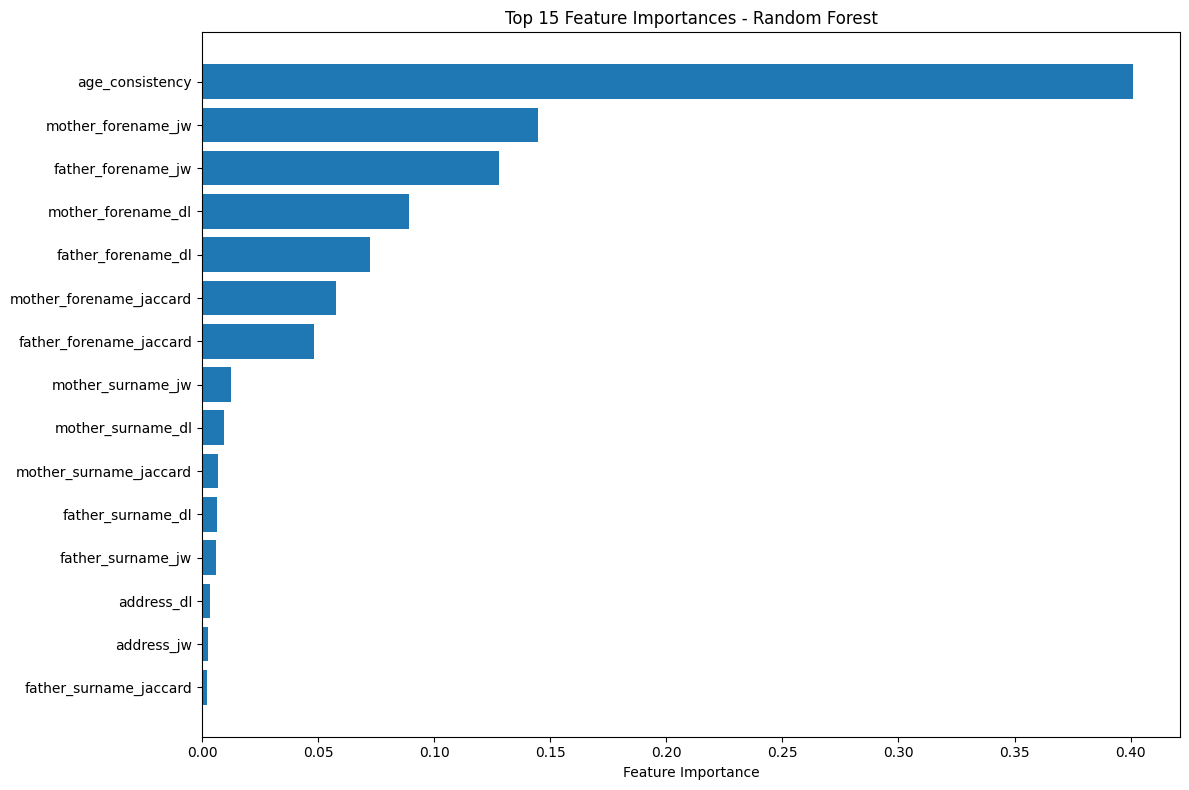

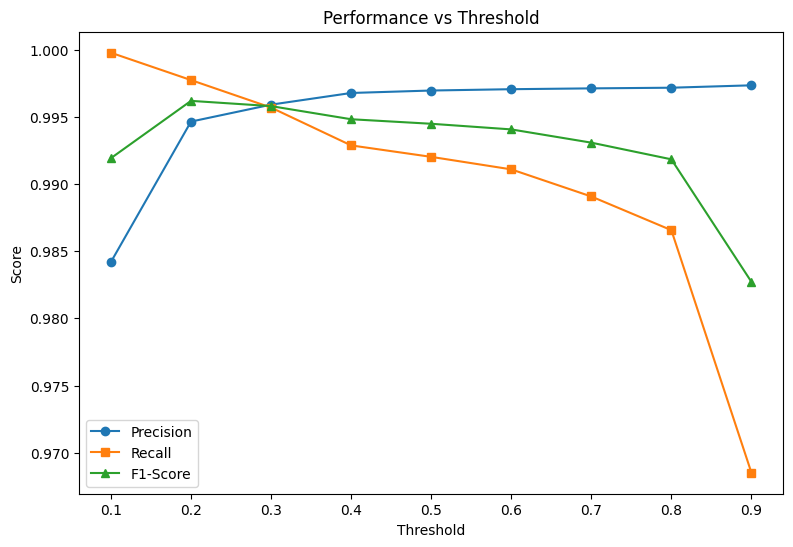


Cross-Validation Summary:
5-Fold Stratified Cross-Validation Results:
Precision: 0.9970 (+/- 0.0004)
Recall: 0.9921 (+/- 0.0005)
F1: 0.9945 (+/- 0.0002)

Final Model Performance on Test Set:
Total record pairs evaluated: 649513
Actual matches in test set: 178184
Predicted matches in test set: 177301
True positives: 176764
False positives: 537
False negatives: 1420
True negatives: 16133

Test Set Performance:
Precision: 0.9970
Recall: 0.9920
F1-Score: 0.9945

Sample predictions:
   birth_id  death_id  actual_label  predicted_label  prediction_probability
0   2905469   2905469             1                1                0.925577
1    859550   1486306             0                0                0.000002
2   1603478   1603478             1                1                0.968185
3   1365102   1365102             1                1                0.959987
4   1660647   1660647             1                1                0.949859
5   1399077   1399077             1                1  

In [13]:

# %% [markdown]
# ## Step 5: Evaluation

# %%
# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Classification Results:")
print("=" * 30)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# %%
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# %%
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Match', 'Match'],
            yticklabels=['No Match', 'Match'])
plt.title('Confusion Matrix - Birth-Death Record Linkage')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# %%
# Feature importance analysis
feature_names = []
string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
               'mother_forename', 'mother_surname', 'address']

for col in string_cols:
    feature_names.extend([f'{col}_jw', f'{col}_dl', f'{col}_jaccard'])
feature_names.append('age_consistency')

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# %%
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

thresholds = np.arange(0.1, 1.0, 0.1)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int) 
    # the cutoff point of pred_proba to know what probabilities should we say "this is a match"
    if np.sum(y_pred_thresh) > 0:
        precisions.append(precision_score(y_test, y_pred_thresh))
        recalls.append(recall_score(y_test, y_pred_thresh))
        f1_scores.append(f1_score(y_test, y_pred_thresh))
    else:
        precisions.append(0)
        recalls.append(0)
        f1_scores.append(0)

plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='s')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance vs Threshold')
plt.legend()
# plt.grid(True)

# plt.tight_layout()
plt.show()

# %%
# Summary statistics
print("\nCross-Validation Summary:")
print("=" * 50)
print("5-Fold Stratified Cross-Validation Results:")
for metric in metrics:
    test_scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()}: {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")

print("\nFinal Model Performance on Test Set:")
print("=" * 50)
print(f"Total record pairs evaluated: {len(candidate_pairs)}")
print(f"Actual matches in test set: {np.sum(y_test)}")
print(f"Predicted matches in test set: {np.sum(y_pred)}")
print(f"True positives: {cm[1,1]}")
print(f"False positives: {cm[0,1]}")
print(f"False negatives: {cm[1,0]}")
print(f"True negatives: {cm[0,0]}")
print(f"\nTest Set Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# %%

# Sample prediction results
# Save results with correct candidate pairs alignment
pairs_test_array = np.array(pairs_test)

results_df = pd.DataFrame({
    'birth_id': pairs_test_array[:, 0],          
    'death_id': pairs_test_array[:, 1],
    'actual_label': y_test,
    'predicted_label': y_pred,
    'prediction_probability': y_pred_proba
})
print(f"\nSample predictions:")
print(results_df.head(10))

print("=" * 80)

# view the inside data of FP that we missed
false_positives = results_df[(results_df['actual_label'] == 0) & 
                            (results_df['predicted_label'] == 1)]

print(f"\nTotal False Positives: {len(false_positives)}")

if len(false_positives) > 0:
    fp_sorted = false_positives.sort_values('prediction_probability', ascending=False)
    print(f"Top 10 False Positives:")
    print(fp_sorted.head(10).to_string(index=False))
else:
    print("🎉 No False Positives!")

print("=" * 80)

# view the inside data of FN that we missed
false_negative = results_df[(results_df['actual_label'] == 1) & 
                            (results_df['predicted_label'] == 0)]

print(f"\nTotal False Negatives: {len(false_negative)}")

if len(false_negative) > 0:
    fn_sorted = false_negative.sort_values('prediction_probability', ascending=False)
    print(f"Top 10 False Negatives:")
    print(fn_sorted.head(10).to_string(index=False))
else:
    print("🎉 No False Negatives!")

## Bayesian Optimisation (500k data ver.)

In [14]:
# %%
# Bayesian Optimization with modAL - Following Official Documentation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel as C
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI, max_UCB, max_PI

print("Starting Bayesian Optimization with modAL (Following Documentation)...")
print("=" * 60)

# %%
# Define the Parameter Space (Following modAL Pattern)
print("Creating parameter space...")


def create_parameter_grid(n_samples=5000):
    """
    Create random parameter samples instead of full grid - most efficient for large spaces
    """
    np.random.seed(42)
    
    # Generate random samples for each parameter
    param_combinations = np.random.random((n_samples, 4))
    
    return param_combinations


def denormalize_params(normalized_params):
    """
    Convert normalized parameters [0,1] to actual hyperparameter values
    """
    n_estimators = int(50 + normalized_params[0] * 450)      # 50-500
    max_depth = int(3 + normalized_params[1] * 17)           # 3-20
    min_samples_split = int(2 + normalized_params[2] * 8)    # 2-10
    min_samples_leaf = int(1 + normalized_params[3] * 9)     # 1-10
    
    return n_estimators, max_depth, min_samples_split, min_samples_leaf

# Create parameter space (this might be large, so we'll sample from it)
print("Generating parameter combinations...")
full_param_space = create_parameter_grid()
print(f"Full parameter space size: {full_param_space.shape}")

# Sample a subset for computational efficiency
np.random.seed(42)
n_samples = min(5000, len(full_param_space))  # Use max 5000 points
sample_indices = np.random.choice(len(full_param_space), size=n_samples, replace=False)
X_param_space = full_param_space[sample_indices]

print(f"Sampled parameter space size: {X_param_space.shape}")

# %%
# Define the Objective Function (Black Box)
def objective_function(params):
    """
    Objective function to optimize
    Returns POSITIVE values (unlike previous version that returned negative)
    """
    # Handle both single parameter set and batch
    if params.ndim == 1:
        params = params.reshape(1, -1)
    
    results = []
    for param_set in params:
        try:
            n_estimators, max_depth, min_samples_split, min_samples_leaf = denormalize_params(param_set)
            
            # Train Random Forest with these hyperparameters
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42,
                class_weight='balanced'
            )
            
            # Use your existing data
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            # Return POSITIVE F1 (modAL maximizes by default)
            results.append(f1)
            
        except Exception as e:
            # Return a bad score if hyperparameters cause errors
            results.append(0.0)
    
    return np.array(results) if len(results) > 1 else results[0]

# %%
# Initialize Bayesian Optimization (Following modAL Documentation Pattern)
print("Initializing Bayesian Optimizer...")

# Define the Gaussian Process model (like in modAL docs)
kernel = Matern(length_scale=1.0) 
regressor = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    random_state=42,
    alpha=1e-6,
    normalize_y=True
)

# Select initial training points (like in modAL docs)
initial_sample_size = 5
np.random.seed(42)
initial_indices = np.random.choice(len(X_param_space), size=initial_sample_size, replace=False)

# Following modAL pattern: X_initial, y_initial
X_initial = X_param_space[initial_indices]
print("Evaluating initial samples...")
y_initial = []

for i, params in enumerate(X_initial):
    print(f"  Initial sample {i+1}/{len(X_initial)}")
    n_est, max_d, min_split, min_leaf = denormalize_params(params)
    print(f"    Params: n_est={n_est}, max_depth={max_d}, min_split={min_split}, min_leaf={min_leaf}")
    
    y_val = objective_function(params)
    y_initial.append(y_val)
    print(f"    F1-Score: {y_val:.4f}")

y_initial = np.array(y_initial).reshape(-1, 1)  # modAL expects column vector

print(f"Initial evaluations: {y_initial.ravel()}")
print(f"Best initial F1-Score: {np.max(y_initial):.4f}")

# Create Bayesian Optimizer
# find some data (randomly) to input/use inside the Gaussian Process Regressor
# coz GP cannot run without some initial data
optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=X_initial,
    y_training=y_initial,
    query_strategy=max_EI  # Expected Improvement
)

print("Bayesian Optimizer initialized!")
print(f"Acquisition function: Expected Improvement (EI)")

# %%
# Bayesian Optimization Loop (Following modAL Documentation)
# print(f"\nStarting Bayesian Optimization Loop...")
# print("=" * 40)

# Track results
bo_results = {
    'iteration': [],
    'best_f1': [],
    'current_f1': [],
    'best_params': [],
    'current_params': [],
    'n_estimators': [],
    'max_depth': [],
    'min_samples_split': [],
    'min_samples_leaf': []
}

# Remove initial samples from search space
remaining_indices = np.setdiff1d(range(len(X_param_space)), initial_indices)
X_search_space = X_param_space[remaining_indices]

# Track best so far
best_f1_so_far = np.max(y_initial)
best_idx = np.argmax(y_initial)
best_params_so_far = X_initial[best_idx]

# print(f"Initial best F1-Score: {best_f1_so_far:.4f}")

# Store initial results
n_est, max_d, min_split, min_leaf = denormalize_params(best_params_so_far)
bo_results['iteration'].append(0)
bo_results['best_f1'].append(best_f1_so_far)
bo_results['current_f1'].append(best_f1_so_far)
bo_results['best_params'].append(best_params_so_far.copy())
bo_results['current_params'].append(best_params_so_far.copy())
bo_results['n_estimators'].append(n_est)
bo_results['max_depth'].append(max_d)
bo_results['min_samples_split'].append(min_split)
bo_results['min_samples_leaf'].append(min_leaf)



Starting Bayesian Optimization with modAL (Following Documentation)...
Creating parameter space...
Generating parameter combinations...
Full parameter space size: (5000, 4)
Sampled parameter space size: (5000, 4)
Initializing Bayesian Optimizer...
Evaluating initial samples...
  Initial sample 1/5
    Params: n_est=482, max_depth=18, min_split=4, min_leaf=8
    F1-Score: 0.9948
  Initial sample 2/5
    Params: n_est=326, max_depth=4, min_split=5, min_leaf=7
    F1-Score: 0.9935
  Initial sample 3/5
    Params: n_est=231, max_depth=8, min_split=3, min_leaf=3
    F1-Score: 0.9941
  Initial sample 4/5
    Params: n_est=420, max_depth=6, min_split=2, min_leaf=9
    F1-Score: 0.9937
  Initial sample 5/5
    Params: n_est=155, max_depth=10, min_split=9, min_leaf=5
    F1-Score: 0.9944
Initial evaluations: [0.99478051 0.99349737 0.99414069 0.99366182 0.99443519]
Best initial F1-Score: 0.9948
Bayesian Optimizer initialized!
Acquisition function: Expected Improvement (EI)


In [21]:
X_search_space[0:5]

array([[0.15720388, 0.96233806, 0.51836546, 0.07289845],
       [0.90507813, 0.43460765, 0.48809226, 0.92742284],
       [0.14006456, 0.34827462, 0.38954916, 0.51129575],
       [0.30777091, 0.6136379 , 0.89793529, 0.80992442],
       [0.92619407, 0.22867678, 0.63436369, 0.22207587]])

In [22]:
X_search_space

array([[0.15720388, 0.96233806, 0.51836546, 0.07289845],
       [0.90507813, 0.43460765, 0.48809226, 0.92742284],
       [0.14006456, 0.34827462, 0.38954916, 0.51129575],
       ...,
       [0.28155386, 0.84088898, 0.05014402, 0.3966088 ],
       [0.59537337, 0.34274041, 0.22597838, 0.63946844],
       [0.34190528, 0.52767747, 0.2116359 , 0.99563111]], shape=(4980, 4))

In [23]:
X_initial

array([[0.96218591, 0.90148585, 0.27038324, 0.80354178],
       [0.61384595, 0.08771764, 0.3915371 , 0.71332173],
       [0.40287328, 0.29529049, 0.23238432, 0.2810045 ],
       [0.82302831, 0.23094036, 0.09843755, 0.97942051],
       [0.23517024, 0.43074197, 0.92814522, 0.52178477]])

In [24]:
y_initial

array([[0.99478051],
       [0.99349737],
       [0.99414069],
       [0.99366182],
       [0.99443519]])

In [15]:

print(f"\nStarting Bayesian Optimization Loop...")
print("=" * 40)

print(f"Initial best F1-Score: {best_f1_so_far:.4f}")
n_iterations = 15  # Number of BO iterations
# Bayesian optimization loop (exactly like modAL docs)
for iteration in range(n_iterations):
    print(f"\nIteration {iteration + 1}/{n_iterations}")
    print("-" * 30)
    
    if len(X_search_space) == 0:
        print("No more samples to evaluate!")
        break
    
    # Query the next point (following modAL pattern)
    query_idx, query_inst = optimizer.query(X_search_space)
    current_params = query_inst[0]  # Get the parameter vector
    
    # Convert to actual hyperparameters for display
    n_est, max_d, min_split, min_leaf = denormalize_params(current_params)
    
    print(f"Queried parameters:")
    print(f"  n_estimators: {n_est}")
    print(f"  max_depth: {max_d}")
    print(f"  min_samples_split: {min_split}")
    print(f"  min_samples_leaf: {min_leaf}")
    
    # Evaluate the objective function
    print("Evaluating objective function...")
    current_f1 = objective_function(current_params) # return F1 computing by RF
    
    # Teach the optimizer (following modAL pattern)
    optimizer.teach(
        X_search_space[query_idx].reshape(1, -1), 
        np.array([current_f1]).reshape(1, -1)
    )
    
    # Update best found so far
    if current_f1 > best_f1_so_far:
        best_f1_so_far = current_f1
        best_params_so_far = current_params.copy()
        print(f"🎉 New best F1-Score: {best_f1_so_far:.4f}")
    
    # Remove evaluated point from search space
    X_search_space = np.delete(X_search_space, query_idx[0], axis=0)
    
    # Store results
    bo_results['iteration'].append(iteration + 1)
    bo_results['best_f1'].append(best_f1_so_far)
    bo_results['current_f1'].append(current_f1)
    bo_results['best_params'].append(best_params_so_far.copy())
    bo_results['current_params'].append(current_params.copy())
    bo_results['n_estimators'].append(n_est)
    bo_results['max_depth'].append(max_d)
    bo_results['min_samples_split'].append(min_split)
    bo_results['min_samples_leaf'].append(min_leaf)
    
    # Display progress
    print(f"Current F1-Score: {current_f1:.4f}")
    print(f"Best F1-Score so far: {best_f1_so_far:.4f}")
    print(f"Search space remaining: {len(X_search_space)}")

print("\nBayesian Optimization completed!")



Starting Bayesian Optimization Loop...
Initial best F1-Score: 0.9948

Iteration 1/15
------------------------------
Queried parameters:
  n_estimators: 483
  max_depth: 18
  min_samples_split: 4
  min_samples_leaf: 8
Evaluating objective function...
Current F1-Score: 0.9948
Best F1-Score so far: 0.9948
Search space remaining: 4994

Iteration 2/15
------------------------------
Queried parameters:
  n_estimators: 471
  max_depth: 19
  min_samples_split: 5
  min_samples_leaf: 9
Evaluating objective function...
Current F1-Score: 0.9947
Best F1-Score so far: 0.9948
Search space remaining: 4993

Iteration 3/15
------------------------------
Queried parameters:
  n_estimators: 493
  max_depth: 19
  min_samples_split: 2
  min_samples_leaf: 9
Evaluating objective function...
Current F1-Score: 0.9947
Best F1-Score so far: 0.9948
Search space remaining: 4992

Iteration 4/15
------------------------------
Queried parameters:
  n_estimators: 497
  max_depth: 19
  min_samples_split: 8
  min_sample

### B.O. Plot graph


Generating final predictions...
Found optimum at: [0.52129605 0.97601382 0.12555021 0.01694766]
Optimum value: 0.9962
Optimal hyperparameters:
  n_estimators: 284
  max_depth: 19
  min_samples_split: 3
  min_samples_leaf: 1


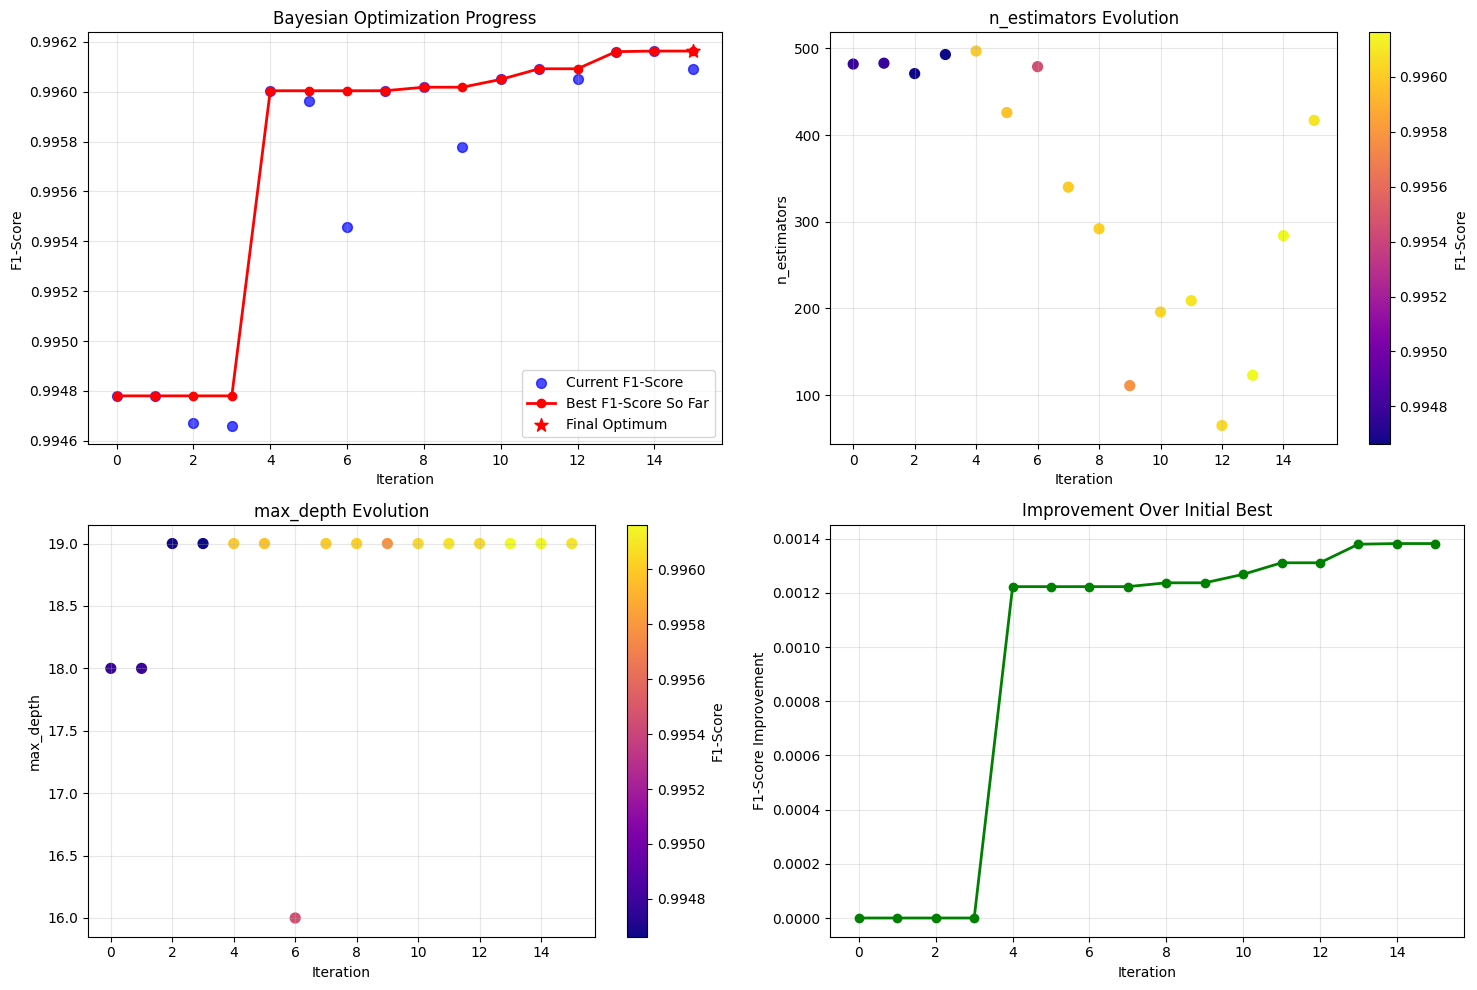


Bayesian Optimization Summary:
Total iterations: 15
Initial best F1-Score: 0.9948
Final best F1-Score: 0.9962
Total improvement: 0.0014

Optimal hyperparameters found:
  n_estimators: 284
  max_depth: 19
  min_samples_split: 3
  min_samples_leaf: 1


In [16]:

# %%
# Get Final Predictions (Following modAL Documentation)
print("\nGenerating final predictions...")

# Get the current optimum (like modAL docs)
X_max, y_max = optimizer.get_max()
print(f"Found optimum at: {X_max}")
print(f"Optimum value: {y_max[0]:.4f}")

# Convert to actual hyperparameters
n_est_opt, max_d_opt, min_split_opt, min_leaf_opt = denormalize_params(X_max)
print(f"Optimal hyperparameters:")
print(f"  n_estimators: {n_est_opt}")
print(f"  max_depth: {max_d_opt}")
print(f"  min_samples_split: {min_split_opt}")
print(f"  min_samples_leaf: {min_leaf_opt}")

# %%
# Plot Results (Following modAL Documentation Style)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

iterations = bo_results['iteration']

# Plot 1: F1-Score Progress (like modAL docs)
axes[0, 0].scatter(iterations, bo_results['current_f1'], 
                   c='blue', s=50, alpha=0.7, label='Current F1-Score')
axes[0, 0].plot(iterations, bo_results['best_f1'], 
                'r-', linewidth=2, marker='o', markersize=6, label='Best F1-Score So Far')
axes[0, 0].scatter(iterations[-1], bo_results['best_f1'][-1], 
                   s=100, c='red', marker='*', label='Final Optimum', zorder=5)

axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].set_title('Bayesian Optimization Progress')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

cmap_color_hue = 'plasma'  # Color map for hue based on F1-Score

# Plot 2: Parameter Evolution - n_estimators
axes[0, 1].scatter(iterations, bo_results['n_estimators'], 
                   c=bo_results['current_f1'], cmap=cmap_color_hue, s=50)
# axes[0, 1].scatter(iterations[-1], bo_results['n_estimators'][-1], 
#                    s=100, c='red', marker='*', zorder=5)
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('n_estimators')
axes[0, 1].set_title('n_estimators Evolution')
axes[0, 1].grid(True, alpha=0.3)
colorbar1 = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
colorbar1.set_label('F1-Score')

# Plot 3: Parameter Evolution - max_depth
axes[1, 0].scatter(iterations, bo_results['max_depth'], 
                   c=bo_results['current_f1'], cmap=cmap_color_hue, s=50)
# axes[1, 0].scatter(iterations[-1], bo_results['max_depth'][-1], 
#                    s=100, c='red', marker='*', zorder=5)
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('max_depth')
axes[1, 0].set_title('max_depth Evolution')
axes[1, 0].grid(True, alpha=0.3)
colorbar2 = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
colorbar2.set_label('F1-Score')

# Plot 4: Convergence Analysis
improvement = np.array(bo_results['best_f1']) - bo_results['best_f1'][0]
axes[1, 1].plot(iterations, improvement, 'g-', linewidth=2, marker='o', markersize=6)
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('F1-Score Improvement')
axes[1, 1].set_title('Improvement Over Initial Best')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Summary (Following modAL Documentation)
print(f"\nBayesian Optimization Summary:")
print("=" * 40)

print(f"Total iterations: {len(bo_results['iteration']) - 1}")
print(f"Initial best F1-Score: {bo_results['best_f1'][0]:.4f}")
print(f"Final best F1-Score: {bo_results['best_f1'][-1]:.4f}")
print(f"Total improvement: {bo_results['best_f1'][-1] - bo_results['best_f1'][0]:.4f}")

print(f"\nOptimal hyperparameters found:")
final_params = bo_results['best_params'][-1]
n_est_final, max_d_final, min_split_final, min_leaf_final = denormalize_params(final_params)
print(f"  n_estimators: {n_est_final}")
print(f"  max_depth: {max_d_final}")
print(f"  min_samples_split: {min_split_final}")
print(f"  min_samples_leaf: {min_leaf_final}")


### Train Optimal Hyperparams in Random Forest
- given the final result of Bayesian Optimisation procedure

In [17]:

# Verify the best configuration
print(f"\nVerifying optimal configuration...")
rf_optimal = RandomForestClassifier(
    n_estimators=n_est_final,
    max_depth=max_d_final,
    min_samples_split=min_split_final,
    min_samples_leaf=min_leaf_final,
    random_state=42,
    class_weight='balanced'
)

rf_optimal.fit(X_train, y_train)
y_pred_optimal = rf_optimal.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score

final_accuracy = accuracy_score(y_test, y_pred_optimal)
final_precision = precision_score(y_test, y_pred_optimal, zero_division=0)
final_recall = recall_score(y_test, y_pred_optimal, zero_division=0)
final_f1_verified = f1_score(y_test, y_pred_optimal, zero_division=0)

print(f"\nFinal Performance with Optimal Parameters:")
print(f"  Accuracy: {final_accuracy:.4f}")
print(f"  Precision: {final_precision:.4f}")
print(f"  Recall: {final_recall:.4f}")
print(f"  F1-Score: {final_f1_verified:.4f}")

print(f"\n🎯 Bayesian Optimization completed successfully!")
print(f"Found optimal hyperparameters using {len(bo_results['iteration'])-1} evaluations")


Verifying optimal configuration...

Final Performance with Optimal Parameters:
  Accuracy: 0.9930
  Precision: 0.9958
  Recall: 0.9965
  F1-Score: 0.9962

🎯 Bayesian Optimization completed successfully!
Found optimal hyperparameters using 15 evaluations
